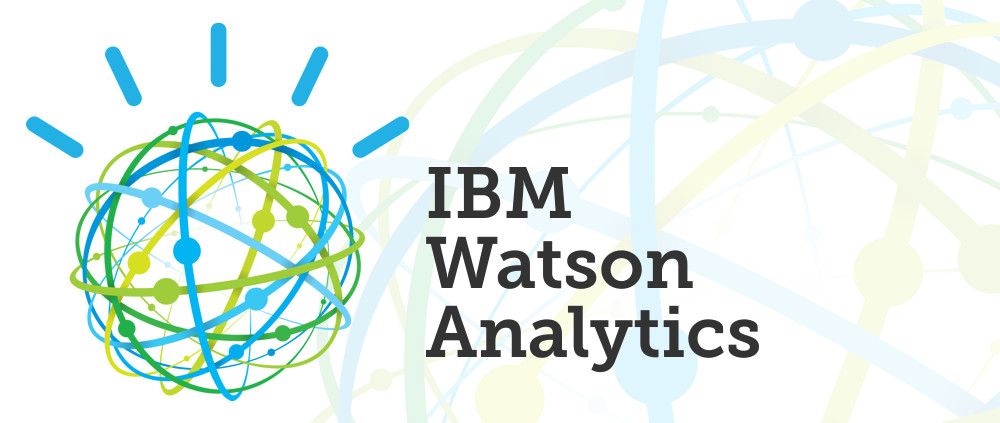



---


IBM provides a natural language understanding API as part of its IBM Watson Analytics Services. Watson NLU is a powerful service that utilizes deep learning for advanced text analytics, simplifying the development of information retrevial tasks and text analysis dependant applications. In the sections below we will explore the different functionalities that the API offers. First, we will desmonstrate how to connect to the API and setup the required IBM libraries. Then, we will demonstrate the text analytics features that NLU offers, followed by a look at how to create custom models with Watson Knowledge Studio. In this notebook, we will demonstrate the lite plan of Watson NLU. However, the only difference between the lite and paid plans is the numer of NLU data units allowed per month, the funtionality itself is identical. 

##Watson Natural Language Understanding API Setup

Firstly, we need to configure the credentials, manage python packages, and install the necessary libraries.

In [2]:
credentials = {
    'IBM_API_KEY_ID': '*******************************',
    'IAM_SERVICE_ID': '*******************************',
    'ENDPOINT': '************************************',
    'IBM_AUTH_ENDPOINT': '*******************************',
    'BUCKET': '*******************************',
    'FILE': '*******************************'
}

## We need to install the Watson python package

In [3]:
pip install --upgrade "ibm-watson>=6.1.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 373 kB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 68 kB 6.9 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 140 kB 39.8 MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-6.1.0-py3-none-any.whl size=370764 sha256=6c28ad08284dab46e609655be3d58e2691cf666c4f4cea86e5561f8de64ea861
  Stored in directory: /root/.cache/pip/wheels/88/69/f3/3e30b078dc358148c52edb76dfa50ab1460f44f440306a8069
Successfully built ibm-watson
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    

In [4]:
pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import json, requests, unicodedata
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 \
    import Features, CategoriesOptions, ClassificationsOptions, ConceptsOptions, EmotionOptions, EntitiesOptions, KeywordsOptions, RelationsOptions, SentimentOptions, SemanticRolesOptions, SyntaxOptions, SyntaxOptionsTokens

In [6]:
authenticator = IAMAuthenticator(credentials['IBM_API_KEY_ID'])
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2022-04-07',
    authenticator=authenticator
)

natural_language_understanding.set_service_url(credentials['ENDPOINT'])

##Suporting Functions to Format Results

We created these functions to organize the results retrieved fromt the NLU API functions. There is one function for each feature that we will explore.

In [7]:
def extract_results(api_res, keys_, doc_type):

    if 'metadata' in keys_:
        df_metadata = pd.DataFrame(api_res['metadata'].items())
        print("\n" + "Metadata" + " "*5 + "#"*15)
        print(df_metadata)
   
    if 'categories' in keys_:
        score = []
        label = []
        for i, data in enumerate(api_res['categories']):
            label.append(api_res['categories'][i]['label'].split('/')[-1])
            score.append(api_res['categories'][i]['score'])
        df_categories = pd.DataFrame({'label': label, 'score':score})
        if doc_type == 'url':
          index = df_categories.index
          index.name = api_res['retrieved_url'].split('www.')[1].split('/')[0]
        print("\n" + "Categories" + " "*5 + "#"*15)
        print(df_categories)    
    
    if 'classifications' in keys_:
        tmp_dict = {}
        class_name = []
        confidence = []
        for i, data in enumerate(api_res['classifications']):
            class_name.append(api_res['classifications'][i]['class_name'])
            confidence.append(api_res['classifications'][i]['confidence'])
        df_classification = pd.DataFrame(tmp_dict.values())
        df_classification.index = tmp_dict.keys()
        df_classification = pd.DataFrame({'class_name': class_name, 'confidence': confidence})  
        print("\n" + "Classification" + " "*5 + "#"*15)
        print(df_classification)
    

    if 'concepts' in keys_:
        text = []
        relevance = []
        for i, data in enumerate(api_res['concepts']):
            text.append(api_res['concepts'][i]['text'])
            relevance.append(api_res['concepts'][i]['relevance'])
        df_concepts = pd.DataFrame({'concepts': text, 'relevance':relevance})
        if doc_type == 'url':
          index = df_concepts.index
          index.name = api_res['retrieved_url'].split('www.')[1].split('/')[0]
        print("\n" + "Concepts" + " "*5 + "#"*15)
        print(df_concepts)
        
    if 'emotion' in keys_:
        item = []
        tmp_dict = {}
        item.append('document')
        tmp_dict['document'] = api_res['emotion']['document']['emotion']
        for i, data in enumerate(api_res['emotion']['targets']):
            item.append(api_res['emotion']['targets'][i])
            tmp_dict[data['text']] = data['emotion']
        df_emotion = pd.DataFrame(tmp_dict.values())
        df_emotion.index = tmp_dict.keys()
        print("\n" + "Emotions" + " "*5 + "#"*15)
        print(df_emotion)


    if 'entities' in keys_:
        name = api_res['entities'][0]['text']
        type_ = api_res['entities'][0]['type']
        sentiment = f"{api_res['entities'][0]['sentiment']['label']}, {api_res['entities'][0]['sentiment']['score']}"
        relevance = api_res['entities'][0]['relevance']
        # description = api_res['entities'][0]['disambiguation']['subtype']
        # df_entities = pd.DataFrame([name, type_, sentiment, relevance, description])
        df_entities = pd.DataFrame([name, type_, sentiment, relevance])
        # df_entities.index = ['name', 'type', 'sentiment', 'relevance']
        df_entities.index = ['name', 'type', 'sentiment', 'relevance']
        print("\n" + "Entities" + " "*5 + "#"*15)
        print(df_entities)

    if 'keywords' in keys_:
        text = []
        sent = []
        rele = []
        tmp_dict = {}
        for i, data in enumerate(api_res['keywords']):
            text.append(api_res['keywords'][i]['text'])
            sent.append(api_res['keywords'][i]['sentiment']['score'])
            rele.append(api_res['keywords'][i]['relevance'])
            tmp_dict[data['text']] = data['emotion']
        df_keywords = pd.DataFrame(tmp_dict.values())
        df_keywords.insert(0, 'sentiment', sent)
        df_keywords.insert(1, 'relevance', rele)
        df_keywords.index = text
        print("\n" + "Keywords" + " "*5 + "#"*15)
        print(df_keywords)
        return df_keywords

    if 'sentiment' in keys_:
        text = []
        sent = []
        lab = []
        text.append('document')
        sent.append(api_res['sentiment']['document']['score'])
        lab.append(api_res['sentiment']['document']['label'])
        for i, data in enumerate(api_res['sentiment']['targets']):
            text.append(api_res['sentiment']['targets'][i]['text'])
            sent.append(api_res['sentiment']['targets'][i]['score'])
            lab.append(api_res['sentiment']['targets'][i]['label'])
        df_sentiment = pd.DataFrame({'text': text, 
                                     'sentiment': sent,
                                    'label': lab})
        # df_sentiment.index = text
        print("\n" + "Sentiment" + " "*5 + "#"*15)
        print(df_sentiment)
        return df_sentiment


# extract_results(r)

##Text Analytics Features

To demonstrate Watson NLU's text analytics features, we will different websites, text snippets, sentences, and other content.

### Categories

This code demonstrates how we can use the NLU API functionality to analyze the categories of a website.

In [8]:
response = natural_language_understanding.analyze(
    url='www.ibm.com',
    features=Features(categories=CategoriesOptions(limit=3))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 1,
    "text_characters": 2038,
    "features": 1
  },
  "retrieved_url": "https://www.ibm.com/us-en/?ar=1",
  "language": "en",
  "categories": [
    {
      "score": 0.973326,
      "label": "/technology & computing/computing/computer software and applications"
    },
    {
      "score": 0.891173,
      "label": "/business and finance/business/business i.t."
    },
    {
      "score": 0.836785,
      "label": "/technology & computing/computing/computer software and applications/operating systems"
    }
  ]
}


In [9]:
extract_results(response, ['categories'], 'url')


Categories     ###############
                                      label     score
ibm.com                                              
0        computer software and applications  0.973326
1                             business i.t.  0.891173
2                         operating systems  0.836785


In [10]:
list_of_urls = ['www.ibm.com','www.tesla.com','www.nvidia.com']
for url in list_of_urls:
    response = natural_language_understanding.analyze(
        url=url,
        features=Features(categories=CategoriesOptions(limit=3))).get_result()
    extract_results(response, ['categories'], 'url')


Categories     ###############
                                      label     score
ibm.com                                              
0        computer software and applications  0.973326
1                             business i.t.  0.891173
2                         operating systems  0.836785

Categories     ###############
                     label     score
tesla.com                           
0                 browsers  0.954117
1               automotive  0.945710
2          auto technology  0.780609

Categories     ###############
                        label     score
nvidia.com                             
0                3-d graphics  0.946491
1           graphics software  0.945639
2                    desktops  0.890689


### Classifications

This code demonstrates how we can use the NLU API functionality to analyze the classifications of a website. This would require constructing a custom model, so only the output of an exanple weather classifier is shown.

In [57]:
response = {
    "classifications": [
        {
            "class_name": "temperature",
            "confidence": 0.562519
        },
        {
            "class_name": "conditions",
            "confidence": 0.433996
        },
        {
            "class_name": "satisfied",
            "confidence": 0.355816
        }
    ],
    "language": "en",
    "usage": {
        "features": 0,
        "text_characters": 36,
        "text_units": 1
    }
}


print(json.dumps(response, indent=2))

{
  "classifications": [
    {
      "class_name": "temperature",
      "confidence": 0.562519
    },
    {
      "class_name": "conditions",
      "confidence": 0.433996
    },
    {
      "class_name": "satisfied",
      "confidence": 0.355816
    }
  ],
  "language": "en",
  "usage": {
    "features": 0,
    "text_characters": 36,
    "text_units": 1
  }
}


In [ ]:
extract_results(response, ['classifications'], 'url')


Classification     ###############
    class_name  confidence
0  temperature    0.562519
1   conditions    0.433996
2    satisfied    0.355816


### Concepts

This code demonstrates how we can use the NLU API functionality to analyze the different concepts found on a website.

In [26]:
response = natural_language_understanding.analyze(
    url='www.blueorigin.com',
    features=Features(concepts=ConceptsOptions(limit=3))).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 770,
    "features": 1
  },
  "retrieved_url": "https://www.blueorigin.com/",
  "language": "en",
  "concepts": [
    {
      "text": "Satellite",
      "relevance": 0.953015,
      "dbpedia_resource": "http://dbpedia.org/resource/Satellite"
    },
    {
      "text": "International Space Station",
      "relevance": 0.946841,
      "dbpedia_resource": "http://dbpedia.org/resource/International_Space_Station"
    },
    {
      "text": "Spacecraft",
      "relevance": 0.842643,
      "dbpedia_resource": "http://dbpedia.org/resource/Spacecraft"
    }
  ]
}


In [27]:
extract_results(response, ['concepts'], 'url')


Concepts     ###############
                                   concepts  relevance
blueorigin.com                                        
0                                 Satellite   0.953015
1               International Space Station   0.946841
2                                Spacecraft   0.842643


### Emotion

Watson is trained to recognize emotions such as sadness, joy, fear, disgust, and anger. This code snippet shows watson analyzing a segment of html.

In [19]:
response = natural_language_understanding.analyze(
    html="<html><head><title>Fruits</title></head><body><h1>Apples and Oranges</h1><p>I love apples! I don't like oranges.</p></body></html>",
    features=Features(emotion=EmotionOptions(targets=['apples','oranges']))).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 36,
    "features": 1
  },
  "language": "en",
  "emotion": {
    "targets": [
      {
        "text": "apples",
        "emotion": {
          "sadness": 0.020855,
          "joy": 0.988253,
          "fear": 0.075412,
          "disgust": 0.016976,
          "anger": 0.016175
        }
      },
      {
        "text": "oranges",
        "emotion": {
          "sadness": 0.244236,
          "joy": 0.075461,
          "fear": 0.044636,
          "disgust": 0.038048,
          "anger": 0.025962
        }
      }
    ],
    "document": {
      "emotion": {
        "sadness": 0.132545,
        "joy": 0.531857,
        "fear": 0.060024,
        "disgust": 0.027512,
        "anger": 0.021068
      }
    }
  }
}


In [ ]:
extract_results(response, ['emotion'], 'html')


Emotions     ###############
           sadness       joy      fear   disgust     anger
document  0.132545  0.531857  0.060024  0.027512  0.021068
apples    0.020855  0.988253  0.075412  0.016976  0.016175
oranges   0.244236  0.075461  0.044636  0.038048  0.025962


### Entities

This code shows how Watson NLU can be used to distinguish and identify the different entities that belong to a website.

In [23]:
response = natural_language_understanding.analyze(
    url='www.spacex.com',
    features=Features(entities=EntitiesOptions(sentiment=True,limit=1))).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 2489,
    "features": 1
  },
  "retrieved_url": "https://www.spacex.com/",
  "language": "en",
  "entities": [
    {
      "type": "Organization",
      "text": "SpaceX",
      "sentiment": {
        "score": 0.648331,
        "label": "positive"
      },
      "relevance": 0.954695,
      "disambiguation": {
        "subtype": [
          "Company",
          "RocketEngineDesigner",
          "RocketManufacturer"
        ],
        "name": "SpaceX",
        "dbpedia_resource": "http://dbpedia.org/resource/SpaceX"
      },
      "count": 3,
      "confidence": 0.999539
    }
  ]
}


In [24]:
extract_results(response, ['entities'], 'url')


Entities     ###############
                            0
name                   SpaceX
type             Organization
sentiment  positive, 0.648331
relevance            0.954695


### Keywords

Watson is able to identify keywords from a website and provide them along with analysis such as their sentiment, emotion, and more.

In [37]:
response = natural_language_understanding.analyze(
    url='www.cnn.com',
    features=Features(keywords=KeywordsOptions(sentiment=True,emotion=True,limit=2))).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 3409,
    "features": 1
  },
  "retrieved_url": "https://www.cnn.com/",
  "language": "en",
  "keywords": [
    {
      "text": "CNN - Breaking News",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.824502,
      "emotion": {
        "sadness": 0.196734,
        "joy": 0.08181,
        "fear": 0.087136,
        "disgust": 0.100798,
        "anger": 0.162275
      },
      "count": 1
    },
    {
      "text": "CNN Newsletters",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.623687,
      "emotion": {
        "sadness": 0.156228,
        "joy": 0.109944,
        "fear": 0.120709,
        "disgust": 0.073768,
        "anger": 0.28451
      },
      "count": 2
    }
  ]
}


In [38]:
extract_results(response, ['keywords'], 'url')


Keywords     ###############
                     sentiment  relevance   sadness       joy      fear  \
CNN - Breaking News          0   0.824502  0.196734  0.081810  0.087136   
CNN Newsletters              0   0.623687  0.156228  0.109944  0.120709   

                      disgust     anger  
CNN - Breaking News  0.100798  0.162275  
CNN Newsletters      0.073768  0.284510  


,sentiment,relevance,sadness,joy,fear,disgust,anger
CNN - Breaking News,0,0.824502,0.196734,0.081810,0.087136,0.100798,0.162275
CNN Newsletters,0,0.623687,0.156228,0.109944,0.120709,0.073768,0.284510


### Metadata

Watson can analyze the metadata. This can be useful for summarizing documents or webpages

In [43]:
response = natural_language_understanding.analyze(
    url='www.fool.com',
    features=Features(metadata= {})).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 797,
    "features": 1
  },
  "retrieved_url": "https://www.fool.com/",
  "metadata": {
    "title": "The Motley Fool",
    "publication_date": "2022-10-28T00:00:00",
    "image": "https://optimize.foolcdn.com/?url=https%3A%2F%2Fg.foolcdn.com%2Fmisc-assets/jester.png&w=400&op=resize",
    "feeds": [
      {
        "link": "https://www.fool.com/a/feeds/partner/googlechromefollow?apikey=5e092c1f-c5f9-4428-9219-908a47d2e2de"
      }
    ],
    "authors": []
  },
  "language": "en"
}


In [44]:
extract_results(response, ['metadata'], 'url')


Metadata     ###############
                  0                                                  1
0             title                                    The Motley Fool
1  publication_date                                2022-10-28T00:00:00
2             image  https://optimize.foolcdn.com/?url=https%3A%2F%...
3             feeds  [{'link': 'https://www.fool.com/a/feeds/partne...
4           authors                                                 []


### Relations

Watson can learn relationships between entities in text.

In [45]:
response = natural_language_understanding.analyze(
    text='Leonardo DiCaprio won Best Actor in a Leading Role for his performance.',
    features=Features(relations=RelationsOptions())).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 1,
    "text_characters": 71,
    "features": 1
  },
  "relations": [
    {
      "type": "awardedTo",
      "sentence": "Leonardo DiCaprio won Best Actor in a Leading Role for his performance.",
      "score": 0.680715,
      "arguments": [
        {
          "text": "Best Actor",
          "location": [
            22,
            32
          ],
          "entities": [
            {
              "type": "EntertainmentAward",
              "text": "Best Actor"
            }
          ]
        },
        {
          "text": "Leonardo DiCaprio",
          "location": [
            0,
            17
          ],
          "entities": [
            {
              "type": "Person",
              "text": "Leonardo DiCaprio"
            }
          ]
        }
      ]
    }
  ],
  "language": "en"
}


In [46]:
r = response
print("Original Sentence\n",r['relations'][0]['sentence'])
print('Waston relations summary\n',f"{r['relations'][0]['arguments'][0]['text']} {r['relations'][0]['type']} {r['relations'][0]['arguments'][1]['text']}")


Original Sentence
 Leonardo DiCaprio won Best Actor in a Leading Role for his performance.
Waston relations summary
 Best Actor awardedTo Leonardo DiCaprio


### Sentiment

Watson NLU can also be used to analyze the sentiment of content or prahases in a website.

In [47]:
response = natural_language_understanding.analyze(
    url='https://en.wikipedia.org/wiki/Emmanuel_Macron',
    features=Features(sentiment=SentimentOptions(targets=['France']))).get_result()
    
json.dumps(response, indent=2)

'{\n  "usage": {\n    "text_units": 5,\n    "text_characters": 50000,\n    "features": 1\n  },\n  "sentiment": {\n    "targets": [\n      {\n        "text": "France",\n        "score": 0.556341,\n        "mixed": "1",\n        "label": "positive"\n      }\n    ],\n    "document": {\n      "score": -0.258357,\n      "mixed": "1",\n      "label": "negative"\n    }\n  },\n  "retrieved_url": "https://en.wikipedia.org/wiki/Emmanuel_Macron",\n  "language": "en",\n  "warnings": [\n    "Text content exceeds 50000 character limit. Only first 50000 characters processed..."\n  ]\n}'

In [48]:
extract_results(response, ['sentiment'], 'url')


Sentiment     ###############
       text  sentiment     label
0  document  -0.258357  negative
1    France   0.556341  positive


,text,sentiment,label
0,document,-0.258357,negative
1,France,0.556341,positive


### Semantics

Watson NLU can also identify the components of sentence structure.

In [49]:
response = natural_language_understanding.analyze(
    text='IBM has one of the largest workforces in the world',
    features=Features(semantic_roles=SemanticRolesOptions())).get_result()

print(json.dumps(response, indent=2))


{
  "usage": {
    "text_units": 1,
    "text_characters": 50,
    "features": 1
  },
  "semantic_roles": [
    {
      "subject": {
        "text": "IBM"
      },
      "sentence": "IBM has one of the largest workforces in the world",
      "object": {
        "text": "one of the largest workforces in the world"
      },
      "action": {
        "verb": {
          "text": "have",
          "tense": "present"
        },
        "text": "has",
        "normalized": "have"
      }
    }
  ],
  "language": "en"
}


In [50]:
r = response
print(f"""
Language: {r['language']}
Original sentence: {r['semantic_roles'][0]['sentence']}
Subject: {r['semantic_roles'][0]['subject']['text']}
Object: {r['semantic_roles'][0]['object']['text']}
Verb: {r['semantic_roles'][0]['action']['verb']['text']}
Verb tense: {r['semantic_roles'][0]['action']['verb']['tense']}
Verb normalized: {r['semantic_roles'][0]['action']['normalized']}
""")


Language: en
Original sentence: IBM has one of the largest workforces in the world
Subject: IBM
Object: one of the largest workforces in the world
Verb: have
Verb tense: present
Verb normalized: have



### Syntax

Watson can be used the analyze the syntax of content.

In [51]:
response = natural_language_understanding.analyze(
    text='With great power comes great responsibility',
    features=Features(
      syntax=SyntaxOptions(
        sentences=True,
        tokens=SyntaxOptionsTokens(
          lemma=True,
          part_of_speech=True,
        )))).get_result()

print(json.dumps(response, indent=2))
r = response

{
  "usage": {
    "text_units": 1,
    "text_characters": 43,
    "features": 1
  },
  "syntax": {
    "tokens": [
      {
        "text": "With",
        "part_of_speech": "ADP",
        "location": [
          0,
          4
        ],
        "lemma": "with"
      },
      {
        "text": "great",
        "part_of_speech": "ADJ",
        "location": [
          5,
          10
        ],
        "lemma": "great"
      },
      {
        "text": "power",
        "part_of_speech": "NOUN",
        "location": [
          11,
          16
        ],
        "lemma": "power"
      },
      {
        "text": "comes",
        "part_of_speech": "VERB",
        "location": [
          17,
          22
        ],
        "lemma": "come"
      },
      {
        "text": "great",
        "part_of_speech": "ADJ",
        "location": [
          23,
          28
        ],
        "lemma": "great"
      },
      {
        "text": "responsibility",
        "part_of_speech": "NOUN",
        "loc

In [52]:
for token in r['syntax']['tokens']:
    for k,v in token.items():
        print(f"{k}:\t{v}")
    print('\n')
#         print(v)

text:	With
part_of_speech:	ADP
location:	[0, 4]
lemma:	with


text:	great
part_of_speech:	ADJ
location:	[5, 10]
lemma:	great


text:	power
part_of_speech:	NOUN
location:	[11, 16]
lemma:	power


text:	comes
part_of_speech:	VERB
location:	[17, 22]
lemma:	come


text:	great
part_of_speech:	ADJ
location:	[23, 28]
lemma:	great


text:	responsibility
part_of_speech:	NOUN
location:	[29, 43]
lemma:	responsibility




## End to end Waton Demo

Here we have a demonstration of how Watson's NLU features could be leveraged to analyze a document all at once. We have a link to the White House's official website with the transcript from a speech Pres Biden recently made on student loan forgiveness. We have written some helper functions and now we just need to enter the URL and let Watson summarize the webpage and speech for us.

In [ ]:
def end_to_end(url):
  
  response = requests.get(url)
  if response.status_code != 200:
    print(f"Status code recieved: {response.status_code}\nPlease try again")
    return None

  soup = BeautifulSoup(response.content, 'html.parser')
  speech = str(soup.find(class_ = 'body-content'))

  response_metadata = natural_language_understanding.analyze(
    url=url,
    features=Features(metadata= {})).get_result()
  extract_results(response_metadata, ['metadata'], 'url')

  response_categories_url = natural_language_understanding.analyze(
      url=url,
      features=Features(categories=CategoriesOptions(limit=3))).get_result()
  extract_results(response_categories_url, ['categories'], 'url')

  response_categories_html = natural_language_understanding.analyze(
      html=speech,
      features=Features(categories=CategoriesOptions(limit=3))).get_result()
  extract_results(response_categories_html, ['categories'], 'html')

  response_concepts = natural_language_understanding.analyze(
      html=speech,
      features=Features(concepts=ConceptsOptions(limit=8))).get_result()
  extract_results(response_concepts, ['concepts'], 'html')

  response_keywords = natural_language_understanding.analyze(
      html=speech,
      features=Features(keywords=KeywordsOptions(sentiment=True,emotion=True,limit=5))).get_result()
  kw = extract_results(response_keywords, ['keywords'], 'html')
  # kw is dataframe with keywords in index, pass as list to emotions analyzer

  response_emotions = natural_language_understanding.analyze(
      html=speech,
      features=Features(emotion=EmotionOptions(targets=list(kw.index)))).get_result()
  extract_results(response_emotions, ['emotion'], 'html')

  response_entities = natural_language_understanding.analyze(
      html=speech,
      features=Features(entities=EntitiesOptions(sentiment=True,limit=3))).get_result()
  extract_results(response_entities, ['entities'], 'html')

  response_sentiment = natural_language_understanding.analyze(
      url=url,
      features=Features(sentiment=SentimentOptions(targets=list(kw.index[0][0])))).get_result()
  # extract_results(response_sentiment, ['sentiment'], 'url')
  print(f"\n\nOverall Sentiment: {response_sentiment['sentiment']['document']['label']}\nscore: {response_sentiment['sentiment']['document']['score']}")

In [ ]:
url = "https://www.whitehouse.gov/briefing-room/speeches-remarks/2022/10/21/remarks-by-president-biden-on-student-loan-forgiveness/"
end_to_end(url)


Metadata     ###############
                  0                                                  1
0             title  Remarks by President Biden on Student Loan For...
1  publication_date                                2022-10-21T00:00:00
2             image  https://www.whitehouse.gov/wp-content/uploads/...
3             feeds                                                 []
4           authors                      [{'name': 'The White House'}]

Categories     ###############
                             label     score
whitehouse.gov                              
0                    student loans  0.944763
1                   personal loans  0.892840
2               financial planning  0.786295

Categories     ###############
                label     score
0       student loans  0.944806
1      personal loans  0.892929
2  financial planning  0.786465

Concepts     ###############
                    concepts  relevance
0                       Debt   0.975092
1               S

## Determining overall sentiment
### Sentiment from the White House

This next demo will tie together several of Watson's NLU capabilities and utilize them to determine the overall sentiment from the last 10 White House press briefings. These include speeches by the president, vice president, and regular press conference transcripts. Python's requests library and BeautifulSoup will be used to load the 10 latest press briefings/speeches from the White House's website. Each link is processed using Watson NLU and the sentiment for each story is reported along with the average sentiment. For the sake of simplicity we are using a naive approach and simply taking the average over the 10 scores. Sentiment is measured from -1 to 1 with -1 being negative and one being positive. If sentiment is >= 0.33 we are labeling it positive, <= -0.33 is negative, and in between neutral.

This is a slightly more realistic application of Watson's NLU tools. A simple use case could be a company looking to determine the overall sentiment from the White House. The sentiment could be used as a feature in some other machine learning application, perhaps a predicting stock prices. Sentiment can change daily so being able to update it quickly is important. By utilizing Watson's NLU tools in a pipeline it is possible to quickly capture this information and put it to use as needed.

In [ ]:
def get_current_events():
  """
  returns dictionary of headlines: links
  """
  response = requests.get("https://www.whitehouse.gov/briefing-room/")
  if response.status_code != 200:
    print(f"Status code error: {response.status_code}\nPlease try again")
    return None
  soup = BeautifulSoup(response.content, 'html.parser')
  recent_articles = soup.find(class_ = 'news-index')
  current_page_links = recent_articles.find_all(class_ = 'news-item__title')
  current_events = {}

  for entry in current_page_links:
    current_events[unicodedata.normalize('NFKD', entry.text.strip())] = entry['href']
  return current_events

# get_current_events()

In [ ]:
def page_summary(url):
  
  response = requests.get(url)
  if response.status_code != 200:
    print(f"Status code recieved: {response.status_code}\nTrying again...")
    return False

  soup = BeautifulSoup(response.content, 'html.parser')
  speech = str(soup.find(class_ = 'body-content'))

  response_metadata = natural_language_understanding.analyze(
    url=url,
    features=Features(metadata= {})).get_result()
  title = response_metadata['metadata']['title']
  pub_date = response_metadata['metadata']['publication_date']

  response_categories_html = natural_language_understanding.analyze(
      html=speech,
      features=Features(categories=CategoriesOptions(limit=1))).get_result()
  cat = response_categories_html['categories'][0]['label'].split('/')[-1]

  response_concepts = natural_language_understanding.analyze(
      html=speech,
      features=Features(concepts=ConceptsOptions(limit=1))).get_result()
  conc = response_concepts['concepts'][0]['text']

  response_emotions = natural_language_understanding.analyze(
      html=speech,
      features=Features(emotion=EmotionOptions(targets=['the']))).get_result() # gets emotions for entire document as long as word is contained
  emot = response_emotions['emotion']['document']['emotion']
  
  cat_con = {'Category': cat, 'Concept': conc}
  cat_con_df = pd.DataFrame(cat_con.items())
  emo_df = pd.DataFrame(emot.items())

  response_sentiment = natural_language_understanding.analyze(
      url=url,
      features=Features(sentiment=SentimentOptions(targets=['the']))).get_result()
  sent = response_sentiment['sentiment']['document']['score']
  lab = response_sentiment['sentiment']['document']['label']


  return cat_con_df, emo_df, sent, lab, pub_date
  

In [ ]:
def main():
  current_events = get_current_events()
  # len(current_events.keys())
  doc_sentiment = []
  doc_label = []
  for headline, url in current_events.items():
    pg_sum = page_summary(url)
    print(headline)
    print(url)
    df, emo_df, sent, lab, pub_date = page_summary(url)
    print(f"Sentiment: {sent} ({lab})\n")
    doc_sentiment.append(sent)
    doc_label.append(lab)
  avg_overall_sentiment = np.sum(np.array(doc_sentiment)) / len(current_events.keys())
  if avg_overall_sentiment >= 0.33:
    overall_sentiment_label = 'positive'
  elif avg_overall_sentiment < -0.33:
    overall_sentiment_label = 'negative'
  else:
    overall_sentiment_label = 'neutral'
      
  print(f"\nOverall sentiment from the 10 latest White House press briefs is {overall_sentiment_label} ({np.round(avg_overall_sentiment, 2)})")



In [ ]:
# will run the above demo
main()

Memorandum on Delegation of Authority Under Section 506(a)(1) of the Foreign Assistance Act of 1961
https://www.whitehouse.gov/briefing-room/presidential-actions/2022/10/28/memorandum-on-delegation-of-authority-under-section-506a1-of-the-foreign-assistance-act-of-1961-3/
Sentiment: 0.77611 (positive

Statement by White House Press Secretary Karine Jean-Pierre on the Attack Against Paul Pelosi
https://www.whitehouse.gov/briefing-room/statements-releases/2022/10/28/statement-by-white-house-press-secretary-karine-jean-pierre-on-the-attack-against-paul-pelosi/
Sentiment: -0.572186 (negative

Statement by President Joe Biden on Personal Consumption Expenditures Price Index Data
https://www.whitehouse.gov/briefing-room/statements-releases/2022/10/28/statement-by-president-joe-biden-on-personal-consumption-expenditures-price-index-data/
Sentiment: -0.292602 (negative

Remarks by President Biden on Micron’s Plan to Invest in Chips Manufacturing
https://www.whitehouse.gov/briefing-room/speeches